In [83]:
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from torch.utils.data import DataLoader, TensorDataset # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

input_data = pd.read_csv('input_data.csv')
output_data = pd.read_csv('output_data.csv')

input_data = input_data.astype(float)
output_data = output_data.astype(float)

X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.01, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(loader)

input_dim = X_train_tensor.shape[1]
model = MLP(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  

num_epochs = 500
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    test_loss = evaluate(model, test_loader, criterion)
    scheduler.step()  
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

torch.save(model.state_dict(), 'mlp_model.pth')


Epoch 1/500, Train Loss: 37.8545, Test Loss: 7.3406
Epoch 2/500, Train Loss: 36.3575, Test Loss: 7.8503
Epoch 3/500, Train Loss: 36.3572, Test Loss: 7.5396
Epoch 4/500, Train Loss: 35.1071, Test Loss: 7.5130
Epoch 5/500, Train Loss: 34.5952, Test Loss: 8.2665
Epoch 6/500, Train Loss: 32.1929, Test Loss: 8.1435
Epoch 7/500, Train Loss: 27.5883, Test Loss: 6.4281
Epoch 8/500, Train Loss: 25.8300, Test Loss: 6.6212
Epoch 9/500, Train Loss: 17.8015, Test Loss: 7.6972
Epoch 10/500, Train Loss: 15.1207, Test Loss: 6.3053
Epoch 11/500, Train Loss: 16.2752, Test Loss: 6.8760
Epoch 12/500, Train Loss: 7.7478, Test Loss: 6.5473
Epoch 13/500, Train Loss: 11.7471, Test Loss: 6.4346
Epoch 14/500, Train Loss: 8.0244, Test Loss: 6.1716
Epoch 15/500, Train Loss: 6.4639, Test Loss: 6.4259
Epoch 16/500, Train Loss: 7.1888, Test Loss: 6.5728
Epoch 17/500, Train Loss: 6.5545, Test Loss: 6.3748
Epoch 18/500, Train Loss: 7.2990, Test Loss: 6.3789
Epoch 19/500, Train Loss: 6.7612, Test Loss: 6.4033
Epoch 20/

In [90]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch

input_data = pd.read_csv('input_data.csv')
output_data = pd.read_csv('output_data.csv')

input_data = input_data.astype(float)
output_data = output_data.astype(float)

scaler = StandardScaler()
input_data_scaled = scaler.fit_transform(input_data)

input_tensor = torch.tensor(input_data_scaled, dtype=torch.float32)

with torch.no_grad():
    predictions = model(input_tensor)

predictions_numpy = predictions.numpy().flatten()

predicted_data = pd.DataFrame({
    'Original_QFI': output_data.values.flatten(),
    'Predicted_QFI': predictions_numpy
})

predicted_data.to_csv('predicted_data.csv', index=False)
print("Predictions saved to 'predicted_data.csv'")


Predictions saved to 'predicted_data.csv'


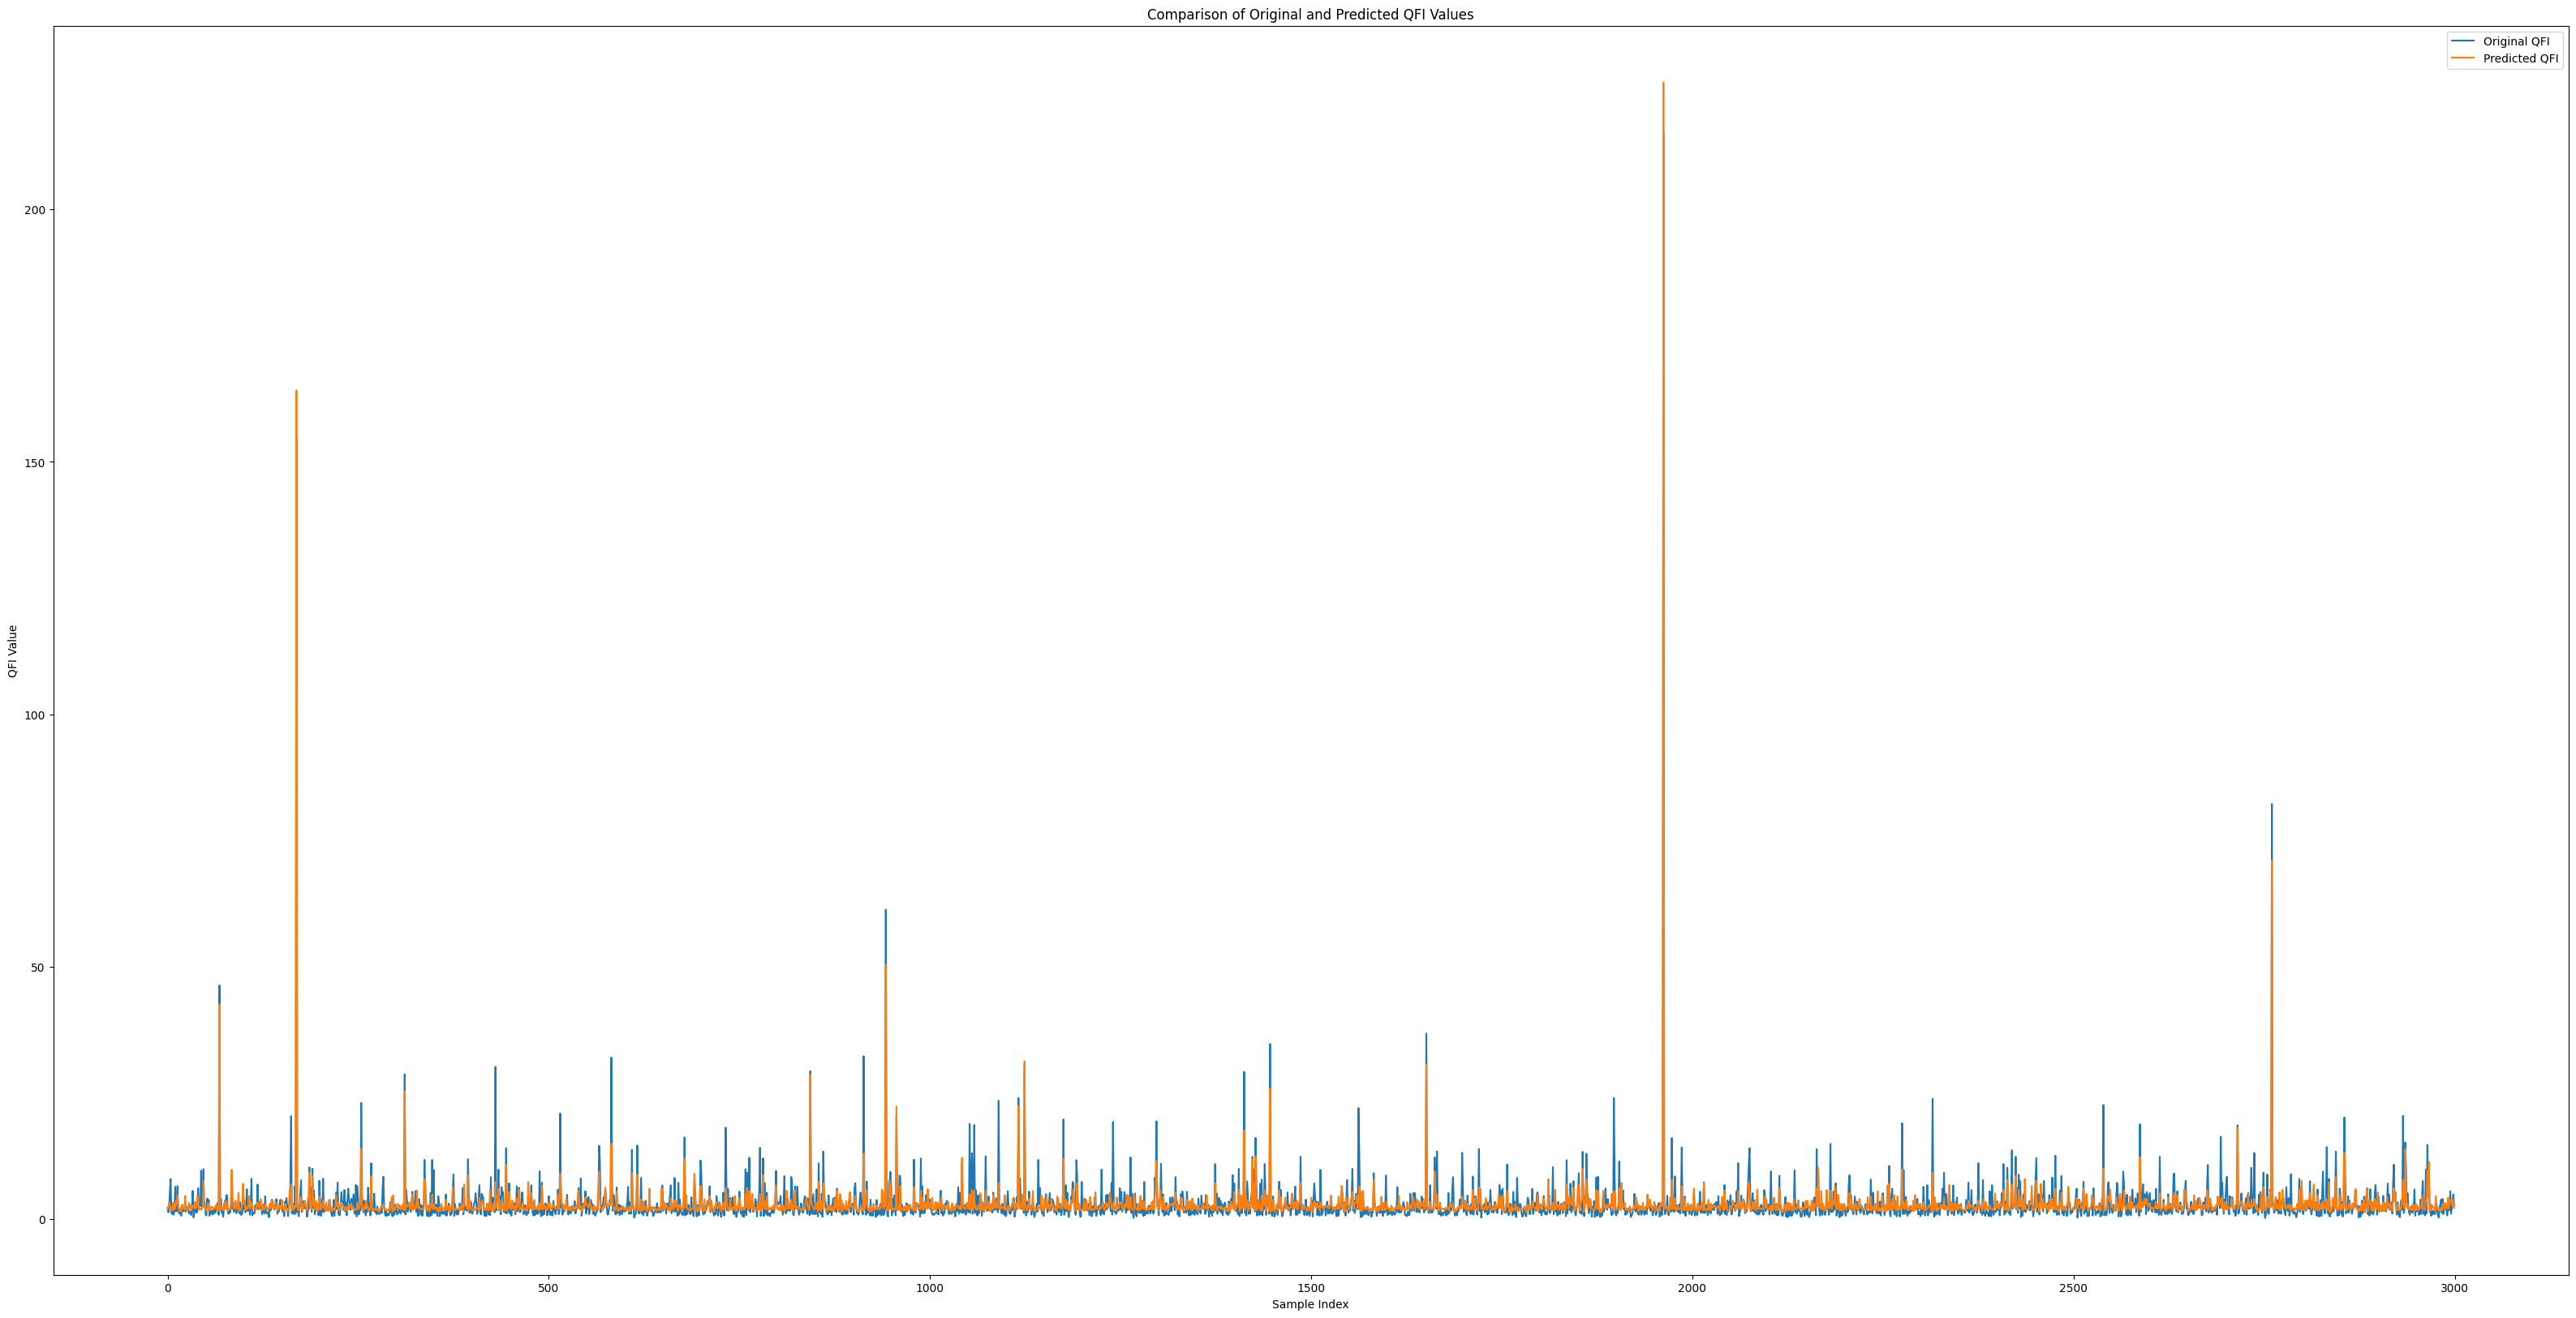

In [92]:
import matplotlib.pyplot as plt

predicted_data = pd.read_csv('predicted_data.csv')

plt.figure(figsize=(40, 20))
plt.plot(predicted_data['Original_QFI'], label='Original QFI')
plt.plot(predicted_data['Predicted_QFI'], label='Predicted QFI')
plt.xlabel('Sample Index')
plt.ylabel('QFI Value')
plt.legend()
plt.title('Comparison of Original and Predicted QFI Values')
plt.show()
